In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from Agents import *
from mtg_experimentation_utilities import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import *

## Equilbrium Experiment Analysis
Below, we will take a look at our equilibrium experiments and answer the following questions:
- Does a deviator end up with a stronger pool than other players, if so, under which circumstances?
- What are the effects on other tables that come from having 1 deviator at the table, who is affected and what's the magnitude?
- How do top archetypes change as a result of deviation? Is there a consolidation of archetypes considered or do more archetypes get covered when introducing deviation?
- Is there a way to explain the relationships between any of the points above (e.g. top archetypes tend to converge in a few archetypes, thus doing X to pool strengths for deviators/non-deviators)?
- Can we better understand the relationship between agents based on any of the information above (e.g. do agents perform similarly, change, how does this affect outcomes?)


In [2]:
def generated_combined_df_for_analysis(df_baseline, df_experiments, batch_id):
    """Given the dataframes for the baseline, experiments, and the batch of simulations to explore, generate a dataset
    grouped at the draft-player level and create features for archetypes, top archetype scores, and whether or 
    not a given player was the deviator """

    #Create aggregated dfs for the baseline and experiment
    blines = df_baseline[df_baseline['batch_id']==batch_id].groupby(['batch_id','draft_number','player','deviating_strategy',
    'majority_strategy','deviating_seat','n_cards_incl_norm']).agg({'top_archetype_score':'first',"top_archetype_index":'first'}).reset_index()

    diffs = df_experiments[df_experiments['batch_id']==batch_id].groupby(['batch_id','draft_number','player','deviating_strategy',
    'majority_strategy','deviating_seat','n_cards_incl_norm']).agg({'top_archetype_score':'first',"top_archetype_index":'first'}).reset_index()

    #Merge the dfs together (since they have the exact same values for these join keys, we can use an inner join without data loss)
    combo = blines.merge(diffs, 'inner',on=['batch_id','draft_number','player','deviating_strategy','majority_strategy','deviating_seat','n_cards_incl_norm'],suffixes=('_baseline','_experiment'))

    combo_exp_indexes = combo.groupby(["deviating_strategy",'majority_strategy','draft_number'])['top_archetype_index_experiment'].value_counts()
    combo_exp_indexes = pd.DataFrame(combo_exp_indexes).rename(columns={'top_archetype_index_experiment':'count_top_archetype_index_experiment'}).reset_index()
    combo = combo.merge(combo_exp_indexes, 'left', ['deviating_strategy','majority_strategy','draft_number',"top_archetype_index_experiment"])

    #Generate new features for difference in pool strengths between baseline/experiment, dummy for changing and # of players who ended up in the same 
    #archetype as the player in the same draft (e.g. of the 8 players, did anyone else end up in archetype A?)
    combo['delta'] = combo['top_archetype_score_experiment'] - combo['top_archetype_score_baseline']
    combo['arch_change'] = np.where(combo['top_archetype_index_baseline']!=combo['top_archetype_index_experiment'],1,0)
    combo["count_top_archetype_index_experiment"].fillna(0,inplace=True)

    #Create variables for switching into different archetypes
    combo['switch_into_arch_w_others'] = np.where(combo['arch_change']==1,np.where(combo['count_top_archetype_index_experiment']>1,1,0),0)
    combo['switch_into_arch_w_self'] = np.where(combo['arch_change']==1,np.where(combo['count_top_archetype_index_experiment']==1,1,0),0)
    combo['deviator'] = np.where(combo['deviating_seat']==combo['player'],1,0)

    #Remove this column since it was just used for feature generation
    combo.drop(columns=['count_top_archetype_index_experiment'],inplace=True)

    return combo
    
def single_seat_heatmap_plotter(heatmap_gb:pd.DataFrame, player:int, title:str='Top Archetype Strength Change Between Baseline and Experiment'):
    """Given a grouped dataframe ready for the heatmap, a player to look at and a title, generate a heatmap for pool strength increases/decreases
    based on deviating/majority strategies on the table for the particular player"""

    heatmap_gb_plot = heatmap_gb.copy()

    #Since both of these would be standard in a batch, we can take the first number here 
    n_cards_in_norm = heatmap_gb['n_cards_incl_norm'][0]
    deviating_seat = heatmap_gb['deviating_seat'][0]

    #Clean up the strings for these strategies
    heatmap_gb_plot['deviating_strategy'] = heatmap_gb_plot['deviating_strategy'].apply(lambda x: x.split('gent')[0][:-2])
    heatmap_gb_plot['majority_strategy'] = heatmap_gb_plot['majority_strategy'].apply(lambda x: x.split('gent')[0][:-2])

    #Create a pivot table for the player where the axes are the majority/dev strategies and values are the pool strength changes
    pt = pd.pivot_table(heatmap_gb_plot[heatmap_gb_plot['player']==player],
    index=['deviating_strategy'],columns=['majority_strategy'],values=['delta'],fill_value=0)
    pt.columns = pt.columns.get_level_values(1)

    #Convert heatmap into a heatmap with annotations to show the value for the pool strength change
    sns.heatmap(pt,annot=True, fmt='.2f')

    #Add subtitle/title
    plt.suptitle(title,fontweight='bold',ha='center')
    subtitle = 'for player in seat {} (deviating seat = {})'.format(str(player),str(deviating_seat))
    plt.title(subtitle,ha='center')

    #Add labels to both axes 
    plt.xlabel('Majority Strategy',fontweight='bold',ha='center')
    plt.xticks(rotation = 45)
    plt.ylabel('Deviating Strategy',fontweight='bold',ha='center')
    plt.yticks(rotation=45)

    #and add annotations to highlight the # cards used to determine pool strength
    plt.gcf().text(0.5, -.15,'Strength is the sum of the top {} weight values in that archetype in a pool of cards'.format(n_cards_in_norm),
    ha='center',style='italic')
    plt.show()

def all_seats_comparison_bar_plotter(bar_gb:pd.DataFrame, deviating_strategy:str,majority_strategy:str,
ymin:int=0, title='Difference in Top Archetype Strength Across Seats'):
    """Create a bar chart that shows the baseline/experimental pool strengths in each seat
    given a dataframe that is preprocessed for these groupings, a deviating/majority strategy pair, and a y axis minimum"""

    #filter to a given dev/majority pair
    bar_gb_filtered = bar_gb[(bar_gb['deviating_strategy']==deviating_strategy) & (bar_gb['majority_strategy']==majority_strategy)]

    #Add norm cards to variable for text at bottom of chart
    n_cards_in_norm = bar_gb['n_cards_incl_norm'][0]

    #Perform column operations and generate the plot
    bar_gb_filtered.drop(columns=['deviating_strategy','majority_strategy','n_cards_incl_norm'],inplace=True)
    bar_gb_filtered.set_index(['player'],inplace=True)
    bar_gb_filtered.rename(columns={'top_archetype_score_baseline':'baseline',
    'top_archetype_score_experiment':'experiment'},inplace=True)
    bar_gb_filtered.plot(kind='bar',color=['grey', 'black'])

    #Add title for chart
    plt.legend(bbox_to_anchor=[1.35,0.5],loc='center right')
    plt.suptitle(title, fontweight="bold")

    #Optional, add a min on the y axis to make data more visible
    plt.ylim(ymin)

    #String Operations to Prettify agent names (there's some discrepancies with Agent and agent capitalization, so just use gent as our splitter)
    deviating_strategy = deviating_strategy.split('gent')[0][:-2]
    majority_strategy = majority_strategy.split('gent')[0][:-2]
    plt.xticks(rotation=0)
    plt.ylabel('Top Archetype Strength',fontweight='bold')
    plt.xlabel('Player',fontweight='bold')
    plt.title("Majority Strategy:{} Deviating Strategy:{}".format(majority_strategy,deviating_strategy))
    plt.gcf().text(0.5, -.05,'Strength is the sum of the top {} weight values in that archetype in a pool of cards'.format(str(n_cards_in_norm)),
    ha='center',style='italic')
    plt.show()

def change_percentage_bar_subplotter(combined_dataframe:pd.DataFrame, majority_strategy:str, n_cols:int):
    """Generate a figure containing plots with the archetype change rates for each seat and how they deviate (e.g. to their own arch v. to a shared arch)
    for all deviating strategies in an experiment given a combined df and majority strategy"""

    #Group the input df by counting dummy variables; delta arbitrarily chosen as our denominator for the percentages since it would never be null
    changes = combined_dataframe.groupby(['player','majority_strategy','deviating_strategy','deviating_seat']).agg({'arch_change':'sum',
    'switch_into_arch_w_others':'sum',
    'switch_into_arch_w_self':"sum",
    'delta':'count'})

    #perform column operations an clean up value for majority strategy object 
    changes = changes.reset_index()
    deviating_seat = changes['deviating_seat'].iloc[0]
    changes2 = changes[changes['majority_strategy']==majority_strategy]
    maj_strat = changes2['majority_strategy'].iloc[0].split('gent')[0][:-2]
    changes2 = changes2.drop(columns=['majority_strategy','deviating_seat'])
    deviating_strategies = changes2.deviating_strategy.unique()

    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known
    Tot = len(deviating_strategies)
    Cols = n_cols

    # Compute Rows required
    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index
    Position = range(1,Tot + 1)

    # Create main figure
    fig = plt.figure(1,figsize=(16,10))
    fig.suptitle('% of Drafts that Top Archetypes Change Per Seat With Majority Strategy: {}'.format(maj_strat),fontweight='bold',fontsize=18)

    #For each subplot, create the subplot containing the change rates per deviating strategy
    for k in range(Tot):
        short_df = changes2[changes2['deviating_strategy']==deviating_strategies[k]].set_index('player')
        ax = fig.add_subplot(Rows,Cols,Position[k])

        #Generate stacked bar plot as percentage out of 100 
        ax.bar(short_df.index,100*short_df['switch_into_arch_w_others']/short_df['delta'],color='grey',label='Switch into Sharing Arch w/ 1+ Players')
        ax.bar(short_df.index,100*short_df['switch_into_arch_w_self']/short_df['delta'],color='black'
        ,bottom=100*short_df['switch_into_arch_w_others']/short_df['delta'],label='Switch to Arch Unclaimed by Others')

        #Add title and formatting
        ax.set_title('Change Rates With Deviating Strategy: {} in seat {}'.format(deviating_strategies[k].split('gent')[0][:-2], str(deviating_seat)),
        fontsize=12)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    #Add labels to x/y axes and add legend before displaying
    fig.supxlabel("Player Seat Position",fontweight='bold')
    fig.supylabel("% of Drafts Where Top Archetype Changed",fontweight='bold')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right',bbox_to_anchor=[1.15,0.5])
    plt.show()

def experiment_difference_t_tester(combo:pd.DataFrame, return_CL_95_only:bool=True,return_CL_99_only:bool=False):
    """Given our experiment of combined experiment/baselines, see which experiments and seats have statistically signficant differences;
    given what is significant or not, we can further explore the visualization tools to explore the significant relationships discovered"""

    #Get unique players and strategy combos
    players = combo.player.unique()
    unique_list = combo[['deviating_strategy','majority_strategy']].drop_duplicates()

    #Create accumulator to build final df out of
    lst = []

    #Iterate through seats
    for player in players:
        t = combo[combo['player']==player]

        #Iterate through unique pairs and filter to only those experiments
        for idx,pair in unique_list.iterrows():
            new_t = t[(t["deviating_strategy"]==pair[0]) & (t["majority_strategy"]==pair[1])]

            #run a independent samples t test since we are not 
            ttest = ttest_ind(new_t['top_archetype_score_baseline'],new_t['top_archetype_score_experiment'])
            t_value = ttest[0]
            p_value = ttest[1]

            lst.append([player,pair[1],pair[0],t_value,p_value, len(new_t)])

    dz = pd.DataFrame(lst, columns=['seat','majority_strategy','deviating_strategy','t statistic','p value','n_iterations'])
    dz['CL_95_Flag'] = np.where(dz['p value']<0.05,1,0)
    dz['CL_99_Flag'] = np.where(dz['p value']<0.05,1,0)

    if return_CL_95_only == True:
        dz = dz[dz['CL_95_Flag']==1]

    if return_CL_99_only == True:
        dz = dz[dz['CL_99_Flag']==1]

    #Now sort by majority strategy because that will be easier to pair with some of our visualizations
    dz.sort_values(by=['seat','majority_strategy'],inplace=True)
    return dz

In [3]:
#In addition to setting up the agents/baselines for each experiment you will need each of the following
dirpath = "C:/Users/trist/OneDrive/Desktop/drafting-research/"

In [4]:
df = pd.read_csv(dirpath+'equilibrium_data/equilibrium_data_1000_baseline.csv')
dz = pd.read_csv(dirpath+'equilibrium_data/equilibrium_data_1000_diff.csv')

In [5]:
#Run this cell to see which experiments are in the file and their attributes. 
df.groupby('batch_id').agg({'experiment_date':['min','max'],
'majority_strategy':'nunique',
'deviating_strategy':'nunique',
'n_rounds':'first',
'n_cards_in_pack':'first',
'n_cards_incl_norm':'first',
'rotate':'first'})

experiment_date  \
                                                             min   
batch_id                                                           
438adeda-a82a-4a33-83b3-0877fcd92e3a  2022-06-09 14:33:14.299445   

                                                                  \
                                                             max   
batch_id                                                           
438adeda-a82a-4a33-83b3-0877fcd92e3a  2022-06-10 01:46:20.120694   

                                     majority_strategy deviating_strategy  \
                                               nunique            nunique   
batch_id                                                                    
438adeda-a82a-4a33-83b3-0877fcd92e3a                 5                  5   

                                     n_rounds n_cards_in_pack  \
                                        first           first   
batch_id                                                        
438adeda-a82a-4a33-83b3-0877fcd92e3a        3              14   

                                     n_cards_incl_norm rotate  
                                                 first  first  
batch_id                                                       
438adeda-a82a-4a33-83b3-0877fcd92e3a                23      1

In [6]:
# No rotation, 100 iter, norm of 23 cards -> 4ae91361-b128-4b48-b1b5-ccf1405fa1f2	
# Rotation, 100 iter, norm of 23 cards  -> 72efb31a-7af7-4c7c-819a-1d7e8a1a175a	

batch_id = '438adeda-a82a-4a33-83b3-0877fcd92e3a'
combo = generated_combined_df_for_analysis(df, dz, batch_id)

In [7]:
result_gb = combo.groupby(['n_cards_incl_norm','player','majority_strategy','deviating_strategy','deviating_seat'])['delta'].mean().reset_index()
bar_gb = combo.groupby(['player','majority_strategy','deviating_strategy','n_cards_incl_norm']).agg({'top_archetype_score_baseline':'mean','top_archetype_score_experiment':'mean'}).reset_index()
unique_list = bar_gb[['deviating_strategy','majority_strategy']].drop_duplicates().reset_index(drop=True)

### Before we visualize anything, let's assess which seats had statistically significant differences pool strength between baseline (e.g. everyone sharing a strategy) and experimental (e.g. 1 deviator, 7 sharing same majority strategy)

By taking a look at this, we can assess which patterns in our data are statistically significant and can substantiate claims from our visualizations with this information. 

Note this is originally computed using an independent samples T-Test, if you'd like to revise the methodology for this, please do so in the t_tester function above (scipy should have a function that is easy enough to use for this)

In [8]:
experiment_difference_t_tester(combo)

,seat,majority_strategy,deviating_strategy,t statistic,p value,n_iterations,CL_95_Flag,CL_99_Flag
4,0,Greedy Agent_turns_greedy_0,basic_agent,-7.855177,6.463813e-15,1000,1,1
8,0,Greedy Agent_turns_greedy_0,force_k_agent_k_5,-6.896515,7.124416e-12,1000,1,1
12,0,Greedy Agent_turns_greedy_0,hard_agent_8_16_bstart_5_bplateau_1_bezier,-7.515095,8.531314e-14,1000,1,1
16,0,Greedy Agent_turns_greedy_0,med_agent_archs_UB_BR_,-3.127255,1.789885e-03,1000,1,1
0,0,basic_agent,Greedy Agent_turns_greedy_0,11.747733,7.323376e-31,1000,1,1
9,0,basic_agent,force_k_agent_k_5,2.143282,3.221086e-02,1000,1,1
17,0,basic_agent,med_agent_archs_UB_BR_,5.488905,4.559209e-08,1000,1,1
1,0,force_k_agent_k_5,Greedy Agent_turns_greedy_0,8.897890,1.246028e-18,1000,1,1
18,0,force_k_agent_k_5,med_agent_archs_UB_BR_,3.538654,4.113597e-04,1000,1,1
2,0,hard_agent_8_16_bstart_5_bplateau_1_bezier,Greedy Agent_turns_greedy_0,10.907709,5.989284e-27,1000,1,1


c:\Users\trist\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\Users\trist\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


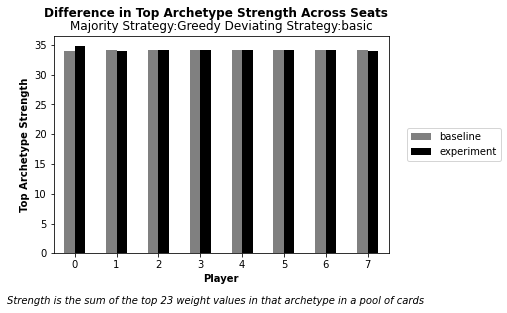

In [9]:
for pair in unique_list.values:
    all_seats_comparison_bar_plotter(bar_gb, pair[0],pair[1])
    break

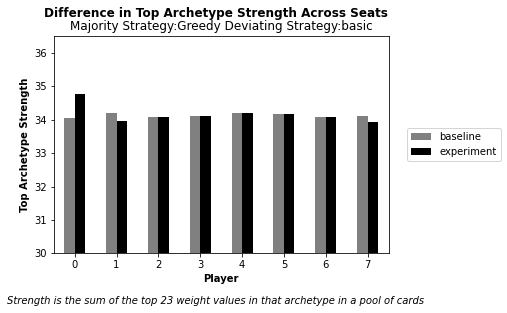

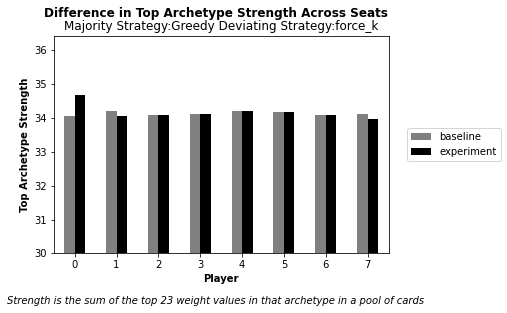

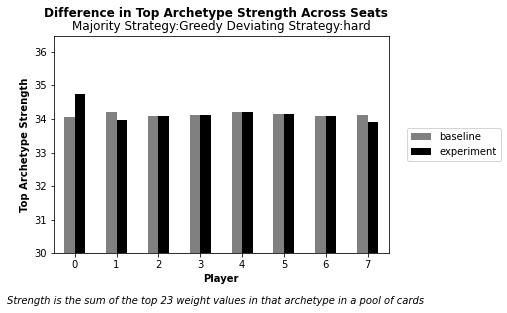

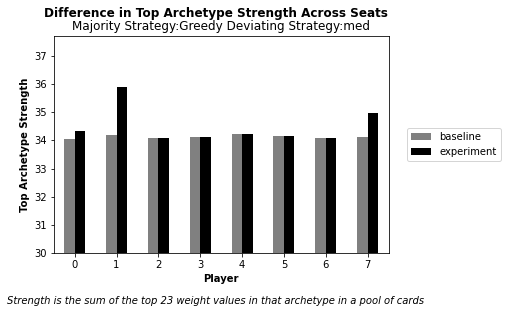

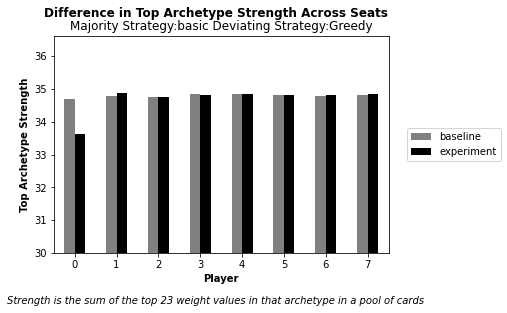

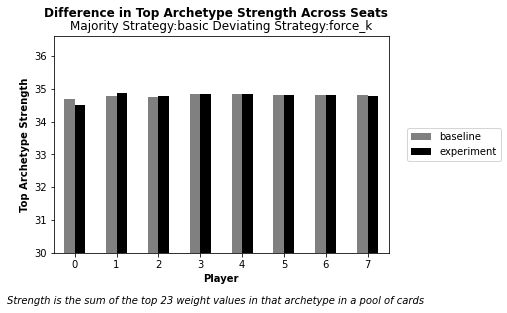

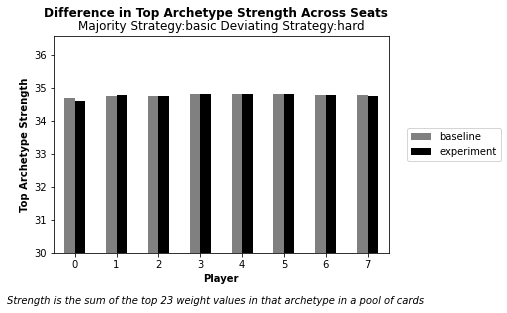

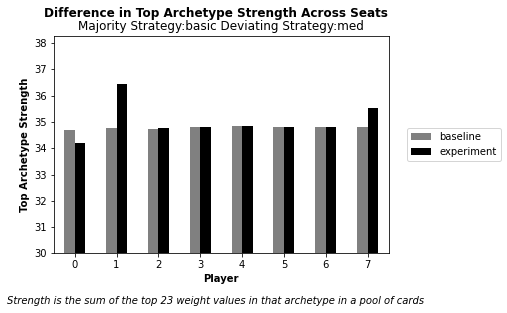

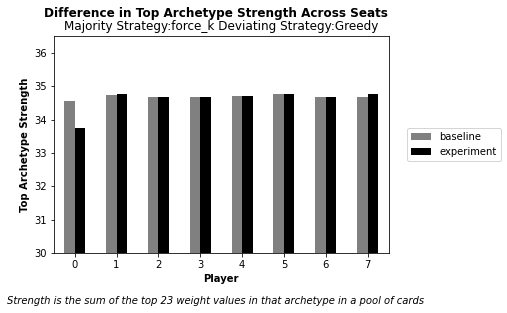

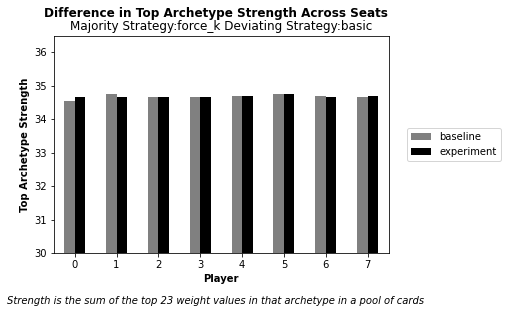

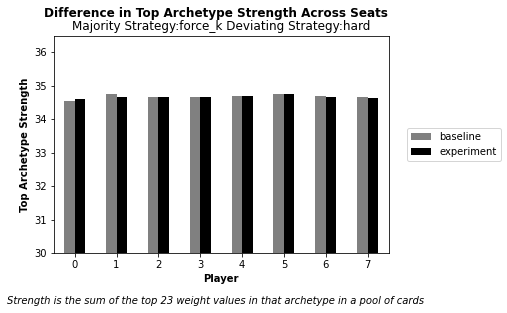

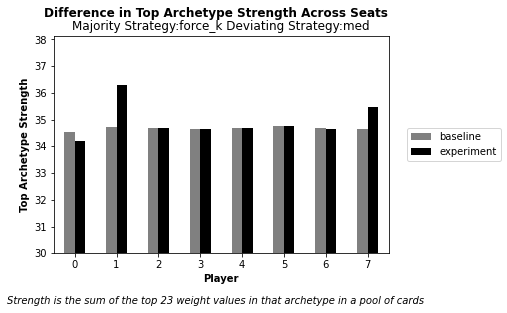

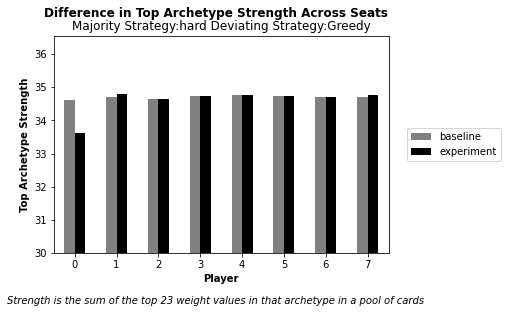

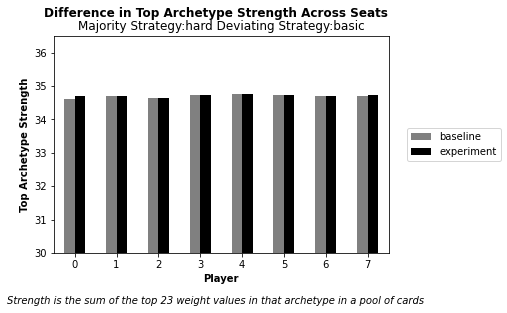

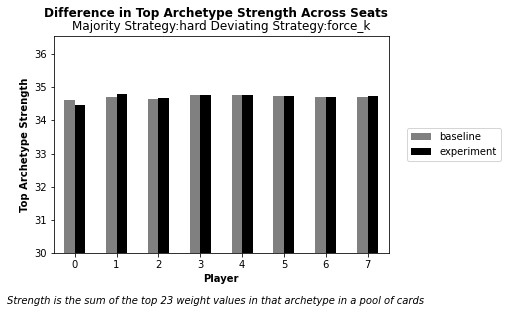

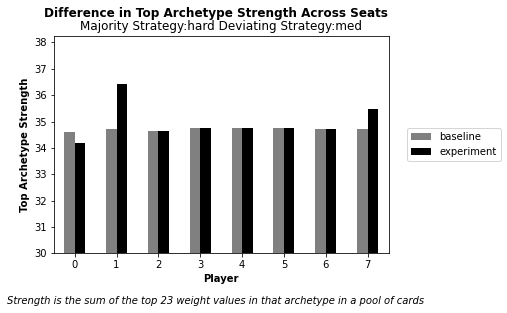

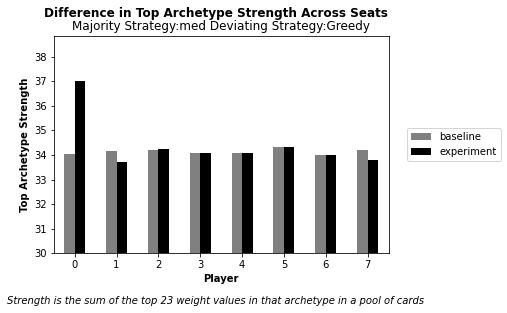

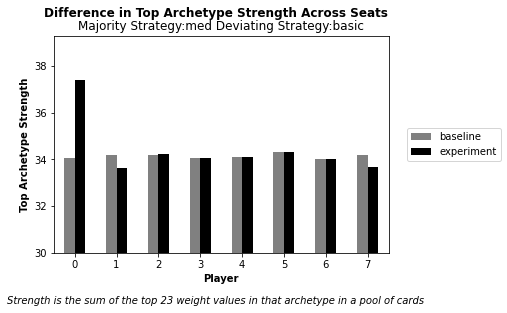

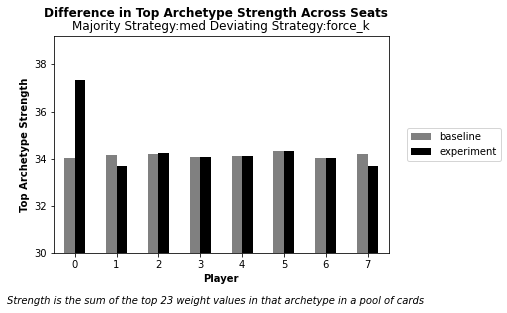

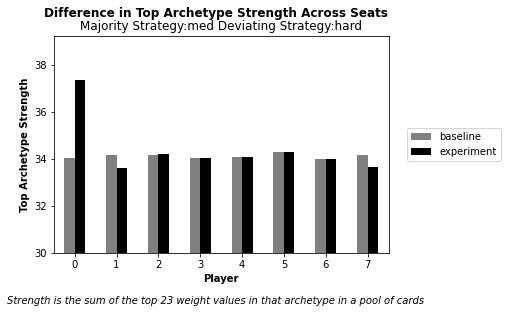

In [10]:
for pair in unique_list.values:
    all_seats_comparison_bar_plotter(bar_gb, pair[0],pair[1],30)

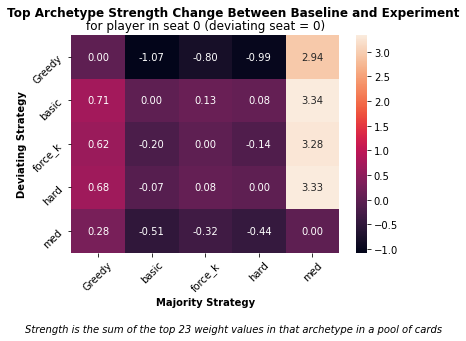

In [11]:
single_seat_heatmap_plotter(result_gb,0)


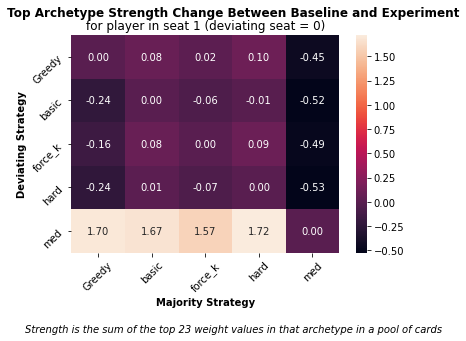

In [12]:
single_seat_heatmap_plotter(result_gb,1)


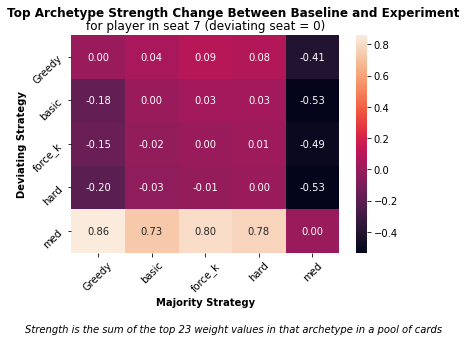

In [13]:
single_seat_heatmap_plotter(result_gb,7)


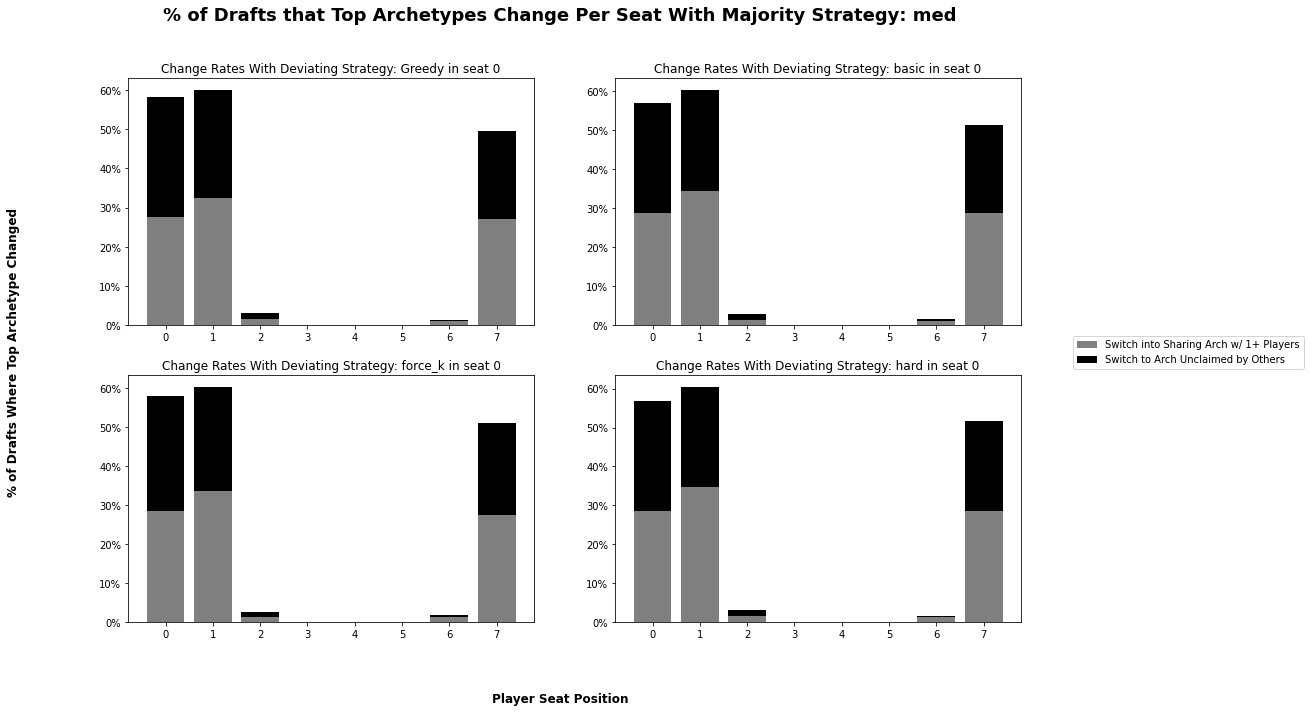

In [14]:
change_percentage_bar_subplotter(combo,'med_agent_archs_UB_BR_',2)

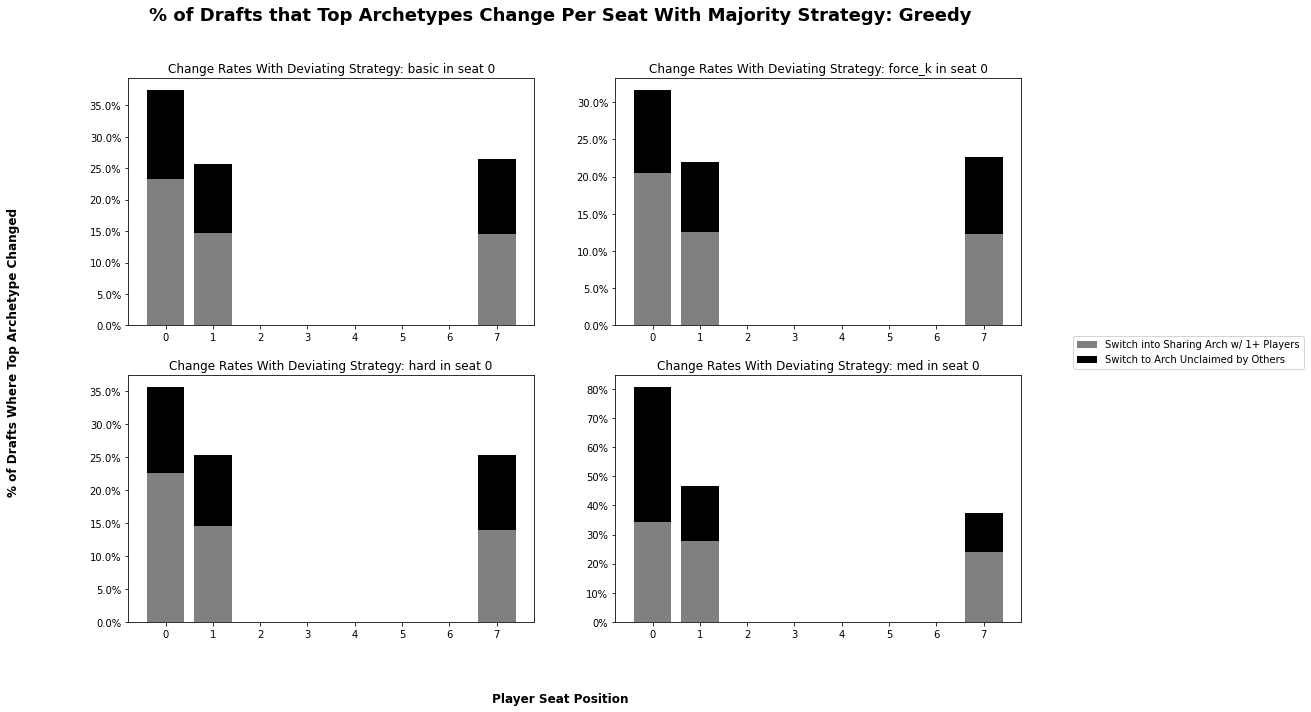

In [15]:
change_percentage_bar_subplotter(combo,'Greedy Agent_turns_greedy_0',2)

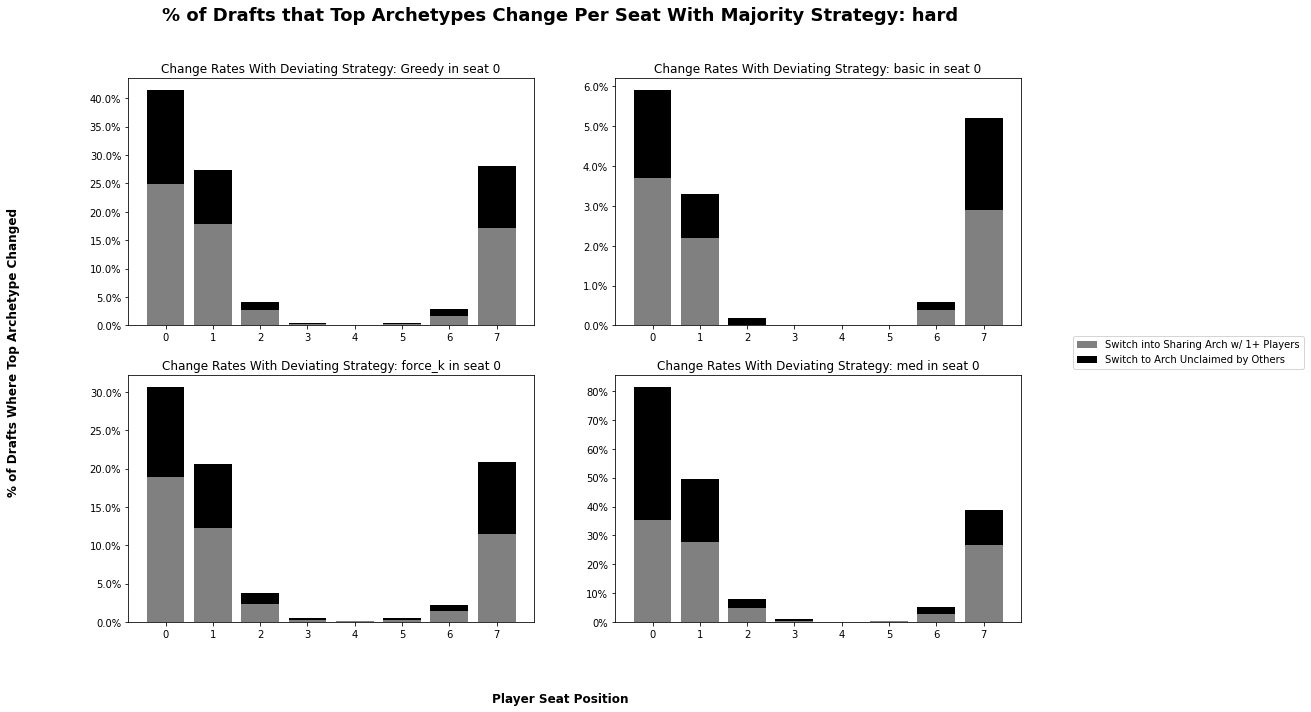

In [16]:
change_percentage_bar_subplotter(combo,'hard_agent_8_16_bstart_5_bplateau_1_bezier',2)

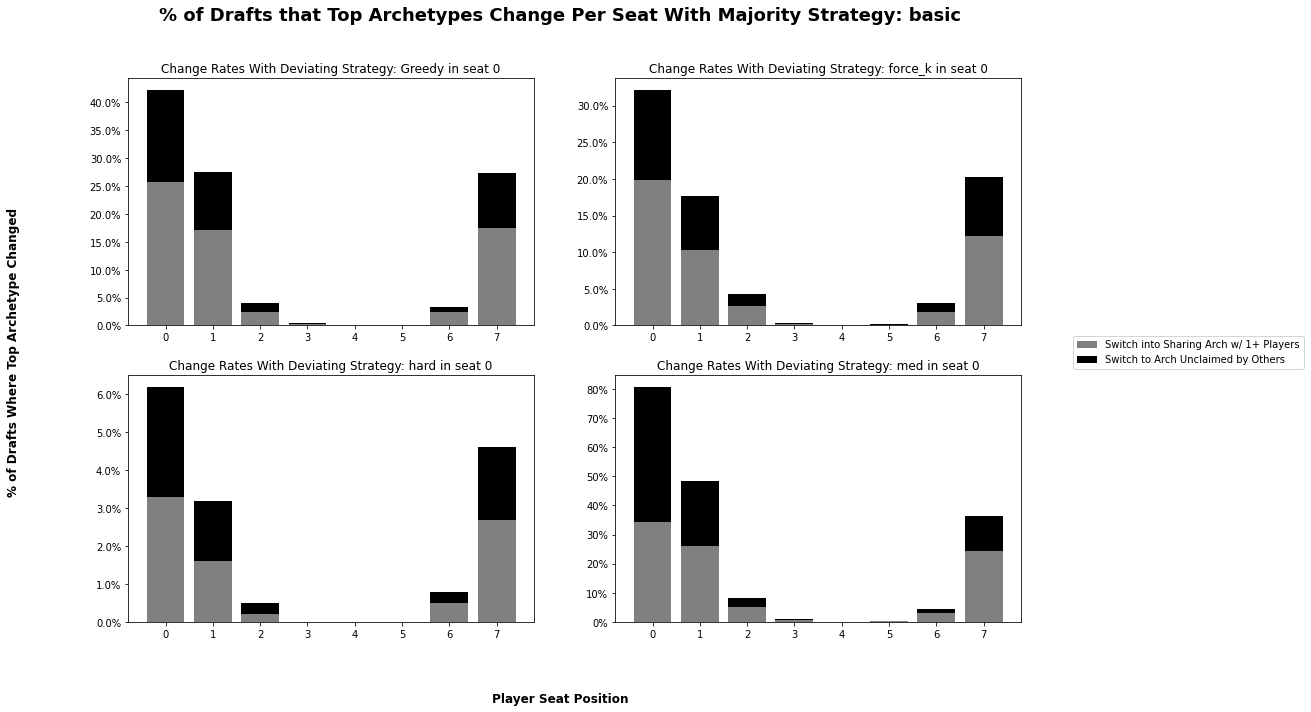

In [17]:
change_percentage_bar_subplotter(combo,'basic_agent',2)

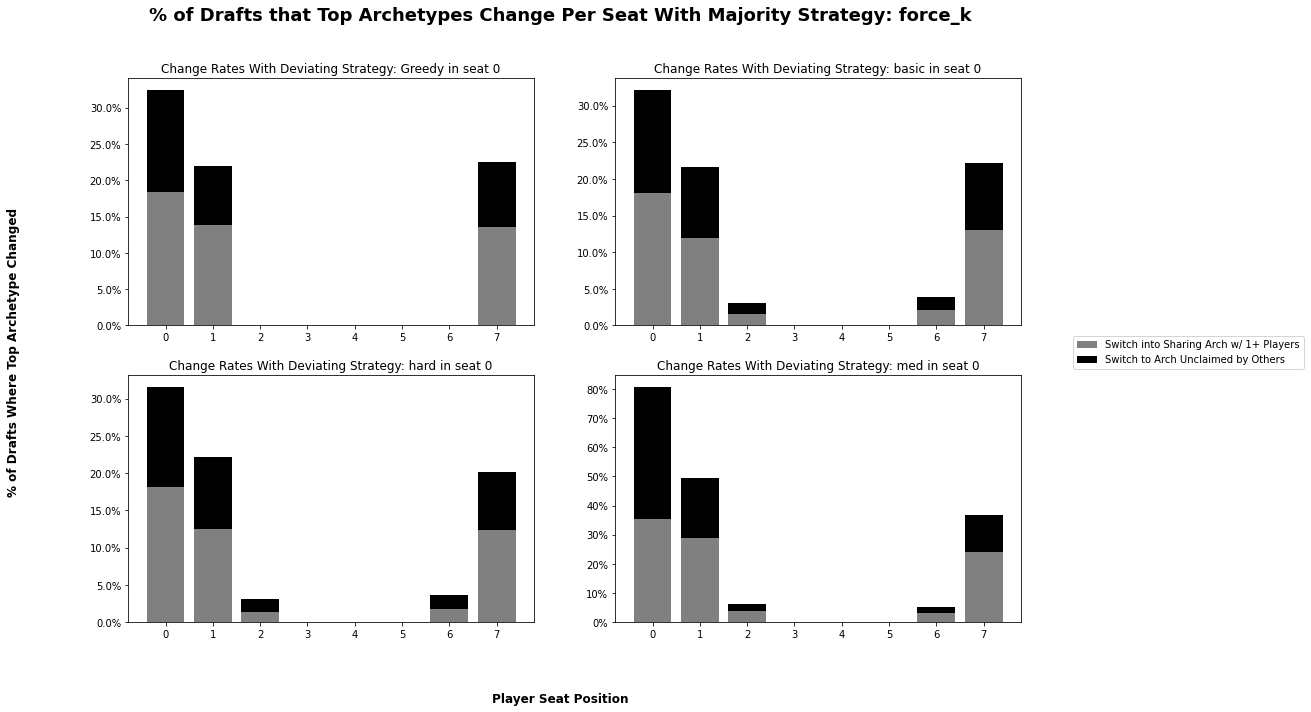

In [18]:
change_percentage_bar_subplotter(combo,'force_k_agent_k_5',2)

In [19]:
#the 80% in the medium graph for forcing seems like an outlier, but the underlying data does show that there is no error in plotting the data and that is 
#what we observe
combo[(combo['majority_strategy']=='force_k_agent_k_5') & (combo['player']==0)].groupby(['arch_change','player','deviating_strategy'])['arch_change'].count()

arch_change  player  deviating_strategy                        
0            0       Greedy Agent_turns_greedy_0                   676
                     basic_agent                                   679
                     hard_agent_8_16_bstart_5_bplateau_1_bezier    684
                     med_agent_archs_UB_BR_                        192
1            0       Greedy Agent_turns_greedy_0                   324
                     basic_agent                                   321
                     hard_agent_8_16_bstart_5_bplateau_1_bezier    316
                     med_agent_archs_UB_BR_                        808
Name: arch_change, dtype: int64

# Takeaways and Paper Talking Points:
- Most of our baseline/experiment pool norms (at top 23 cards per archetype) that tend to be statistically significant are for the deviator and the adjacent seats 
    - This suggests that there is a sort of cascade that comes from sitting next to a deviator
        - There are differences in some of the archetype changes for seats further from the player
        - Since we passed 2x to the right (e.g. from 0->1, 1->2, etc.) and 1x left (0->7, 1->0, etc.), this could explain an unbalanced share of downstream effects
    - A key exception to statistically significant differences is the hard bot and basic bot; the fact that these two were indistinguishable (e.g. majority basic, dev hard and vice versa) suggests that the strategies are similar enough that they have little effect on the pool strength outcome (read more on flexibility below)
        - The nominal archetype change rates in the coupled bar charts are a good visualization of this effect; having a marginally different strategy not only tends to seldom change the strength, but also the top archetype itself.

- The majority and deviating strategies employed have different effects on different players
    - Deviating to Medium in any other environment tends to lead to higher pool values for players
    - The seats next to the deviator (1,7 in our case) tend to only improve (albeit marginally) pool strength when sitting next to a medium bot
    - The difference between basic/hard is small because the hard agent is simply the basic agent with a bias term
    - The greedy strategy appears to isolate other players from archetype changes when the majority (preventing the downstream effect of the deviator to other players)
        - Greedy also appears to marginally be a bad idea for the deviator unless everyone else is doing it
        
- One possible explanation for seeing such stark differences in the medium strategy and less for others is a "flexibility factor"
    - That is, the medium strategy will only consider how a card fits in a given archetype(s) and tend to end up in the archetype the agent is targetting whereas the other strategies are not fixed to a archetype from the start. 
    - With this being said, we observe that when everyone is doing the same medium strategy (targetting the same arch), deviating to a more flexible strategy tends to increase pool strength for the deviator. Furthermore, this player switches to an archetype that is unclaimed at higher rates than the rest of players in these table setups because there is too much competition for the archetype the other 7 bots are targetting. 
    - In cases where the deviator uses the medium strategy, their commitment to a single archetype frees up better cards for their neighbors in other archetypes; since all strategies are more flexible in terms of archetype relative to the medium (e.g. you do not commit to an archetype or two before the draft),they are more free to change when they get higher value cards that aren't so good in the archetype the medium bot likes
